AMD64
Log file exists!


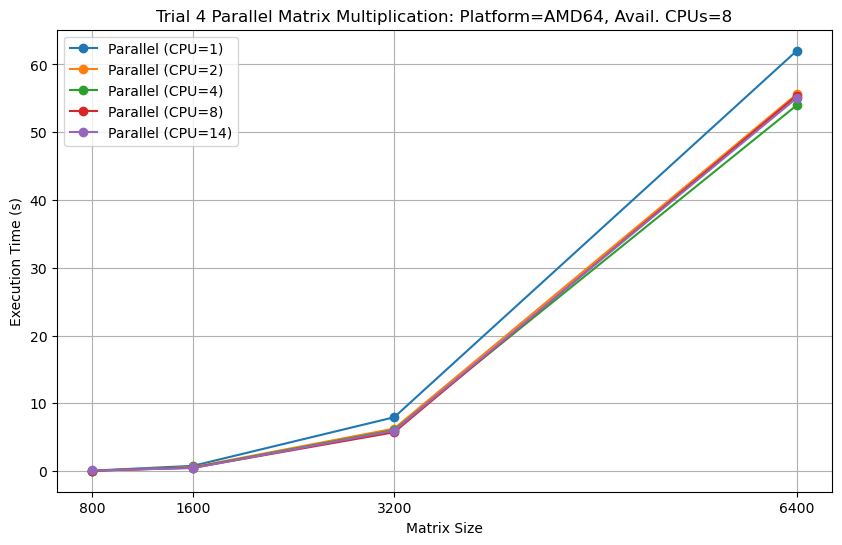

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import time
from concurrent.futures import ThreadPoolExecutor
import concurrent.futures
import logging as log
import platform
import psutil
import os
import datetime as dt


# Total CPUs
total_cpus = psutil.cpu_count()
sys_name = platform.machine()
print(sys_name)

# Set log directory path based on platform
log_dir = ""
if platform.machine() == 'arm64':
    log_dir = f"results/mac/mac_m3"
elif platform.machine() == 'AMD64':
    log_dir = f"results/windows/i7_host"


# Change to log directory
log_file_path = os.path.join(log_dir, f"{sys_name}_performance_metrics.log")

if not os.access(os.path.dirname(log_file_path), os.W_OK):
    print("No write permission for log directory!")
    
#try:
#    with open(log_file_path, 'w') as test_file:
#        test_file.write("Testing file creation.\n")
#    print("File creation test succeeded.")
#except IOError as e:
#    print(f"File creation failed: {e}")
    
#Configure log files
log.basicConfig(
    filename = log_file_path, # Log file name
    level=log.INFO, # Log level
    format="%(asctime)s - %(message)s"
)
log.info("Initial log entry to create the log file.")

for handler in log.getLogger().handlers:
    handler.flush()


#log machine details
log.info("System Details: ")
log.info(f"OS: {psutil.cpu_stats()} {platform.release()}")
log.info(f"CPU: {platform.machine()}")
log.info(f"Logical Cores: {total_cpus}")

def parallel_matrix_multiplication(A, B, num_cpus):
    """
    Performs matrix multiplication in parallel using multiple cores.

    Args:
        A: First numpy matrix.
        B: Second numpy matrix.
        num_cpus: The number of CPUs to use for parallelization.

    Returns:
        The resulting product matrix.
    """
    with ThreadPoolExecutor(max_workers=num_cpus) as executor:
        futures = []
        for i in range(len(A)):
            futures.append(executor.submit(np.matmul, A[i], B))
        results = [f.result() for f in concurrent.futures.as_completed(futures)]
    return np.array(results)

# Define matrix dimensions (experiment with larger sizes for better speedup)
matrix_sizes = [800, 1600, 3200, 6400]

# Number of CPU cores to use
num_cpus = [1, 2, 4, 8, 14]

parallel_times = np.zeros((len(matrix_sizes), len(num_cpus)))


# Measure execution times
for i, size in enumerate(matrix_sizes):
    A = np.random.rand(size, size)
    B = np.random.rand(size, size)

    for j, cpu_count in enumerate(num_cpus):
        # Parallel execution
        start_time = time.time()
        C_parallel = parallel_matrix_multiplication(A, B, cpu_count)
        parallel_times[i][j] = time.time() - start_time
        #parallel_times[i][j] = np.round(parallel_times[i][j], 4)
        
    end_time = time.time()
    elapsed_time = end_time - start_time

#Log the results
log.info(f"Matrix Sizes={matrix_sizes}, Cores={num_cpus}, Times={parallel_times}")

if os.path.exists(log_file_path):
    print("Log file exists!")
else:
    print(f"Log file was not created. {dt.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

# Plot the results
plt.figure(figsize=(10, 6))
for j, cpu_count in enumerate(num_cpus):
    plt.plot(matrix_sizes, parallel_times[:, j], 'o-', label=f'Parallel (CPU={cpu_count})')

plt.xlabel('Matrix Size')
plt.ylabel('Execution Time (s)')
plt.title(f"Trial 4 Parallel Matrix Multiplication: Platform={platform.machine()}, Avail. CPUs={total_cpus}")
plt.legend()
plt.grid()
plt.xticks(matrix_sizes)
plt.show()
